### Importing required pakages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib as mpl
import os

from IPython.core.pylabtools import figsize
from scipy import stats

In [2]:
#Getting Working Directory
os.getcwd()

#Setting style and font size for graphs
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 13

### Importing Data from the CSV file
Missing values in the file are represented by '?'. 

In [3]:
%%time
#load original data into dataframe
file ='D:\\Abhishek\\Personal\\Springboard\\Springboard_DSC\\Capstone Projects\\dataset_diabetes\\diabetic_data.csv'
df1 = pd.read_csv(file, na_values = '?')

Wall time: 930 ms


<string>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


### Understanding the Data. 
Number of columns, whether it was imported correctly, number of missing values etc.

In [236]:
#check shape of the dataset and its columns
df1.shape

(101766, 50)

In [237]:
#Checking if the data was imported correctly
df1.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Missing Value Analysis

### Finding our features with missing value

In [238]:
# Creating a empty table to store Missing Values Count
m_table = pd.DataFrame(columns = ['feature_name', 'null_values', '%missing', 'category_count'])

#Counting the missing values and appending it to m_table
for col in df1.columns:
    null_value = len(df1) - df1[col].count()
    missing = round((null_value/len(df1))*100,2)
    count = len(df1[col].unique())
    m_table = m_table.append(pd.Series([col, null_value, missing,count],index = m_table.columns),ignore_index=True)

#Displaying features which has missing values in descending order
missing = m_table[m_table.null_values != 0].sort_values(by = '%missing',ascending = False).reset_index(drop = True)
display('Missing Value Table')
display(missing)
print('\n')

#Displaying features having only single category
c_count = m_table[m_table.category_count == 1].sort_values(by = '%missing',ascending = False).reset_index(drop = True)
display('Single Category Features')
display(c_count)

'Missing Value Table'

,feature_name,null_values,%missing,category_count
0,weight,98569,96.86,10
1,medical_specialty,49949,49.08,73
2,payer_code,40256,39.56,18
3,race,2273,2.23,6
4,diag_3,1423,1.40,790
5,diag_2,358,0.35,749
6,diag_1,21,0.02,717


'Single Category Features'

,feature_name,null_values,%missing,category_count
0,examide,0,0.0,1
1,citoglipton,0,0.0,1


#### 6 features have missing values.
1) Weight have ~97% missing values. There is poor interpretability of the missing values, so it is best to drop this column. 

2) medical_speciality and payer_code have 40-50% missing values. I have decided to drop it but there are ways to deal with it. I will experiment and use this columns to see if it increases the accuracy of the model. Method to include these columns would be to create a separate category of 'missing'. 

3) race, diag_3, diag_2, diag_1  have only <=2% missing values, so missing rows can be dropped or be replace with mode of the column values. 

5) When all diag are missing, then also it is a bad data. So secondly, removing all rows where where all 3 diag are missing

6) A missing first diagnosis while data have diagnosis second and third, is also a bad data. But second and third diagnosis can give us some idea about the readmission. So we  can either keep this missing values under "missing" category or just ignore the rows. I am going with first one.  

7) For the remaining missing values of Race, it is repalced by mode i.e. Caucasian. 

8) In gender, there are values like "Unknown/Invalid" which are missing. These columns are also dropped




In [239]:
# Droping weight, medical_speciality and payer_code
drop_col1 = ['weight','medical_specialty','payer_code']
df_clean =df1.drop(drop_col1,axis = 1)

# Droping rows with missing values in all 4 columns of race, diag_3, diag_2 and diag_1
drop_col2 = ['diag_1','diag_2', 'diag_3']
df_clean = df_clean.dropna(subset = drop_col2, how = 'all')

# Replacing missing values of 'diag_1, diag_2, diag_3' with Missing = '0'
values = {'diag_1': '0', 'diag_2': '0', 'diag_3': '0'}
df_clean = df_clean.fillna(value = values)

# Droping rows with gender value  as 'Unknown/Invalid'
df_clean = df_clean[df_clean.gender != 'Unknown/Invalid']

# Replacing missing values of 'race' with mode 
df_clean = df_clean.fillna(value={'race': df1.race.mode()[0]})

#df_clean.info()
df_clean.shape

(101762, 47)

Following code will see if there are any more missing values or not

In [240]:
# Creating a empty table to store Missing Values Count
c_table = pd.DataFrame(columns = ['feature_name', 'null_values', '%missing', 'category_count'])

#Counting the missing values and appending it to m_table
for col in df_clean.columns:
    null_value = len(df_clean) - df_clean[col].count()
    missing = round((null_value/len(df_clean))*100,2)
    count = len(df_clean[col].unique())
    c_table = c_table.append(pd.Series([col, null_value, missing,count],index = c_table.columns),ignore_index=True)

#Displaying features which has missing values in descending order
display('Missing Value Table')
display(c_table)
print('\n')

'Missing Value Table'

,feature_name,null_values,%missing,category_count
0,encounter_id,0,0.0,101762
1,patient_nbr,0,0.0,71514
2,race,0,0.0,5
3,gender,0,0.0,2
4,age,0,0.0,10
5,admission_type_id,0,0.0,8
6,discharge_disposition_id,0,0.0,26
7,admission_source_id,0,0.0,17
8,time_in_hospital,0,0.0,14
9,num_lab_procedures,0,0.0,118


## Further Cleaning the Data

Since we are trying to predict readmissions, those patients who died during this hospital admission, have zero probability of readmission. So we should remove those records (discharge_disposition_id = 11, 19,20,21).

In [241]:
# List of Dicharge disposition ids saying that patient got expired or met with a death 
expired = [11,19,20,21]
df_clean = df_clean[~df_clean.discharge_disposition_id.isin(expired)]

While doing missing value analysis, I found that there are two columns where all records have same values (examide and citoglipton). So it would be better to drop these columns also since it cannot provide any information about readmission. 

In [242]:
# Dropping examide and citoglipton
no_info = ['examide','citoglipton']
df_clean = df_clean.drop(no_info,axis = 1)
df_clean.shape

(100110, 45)

Diagnosis columns have more than >600 categories. They are ICD9 Codes describing specific diseases. We can club them in larger categories in accordance with ICD9 to reduce the categories. 

In [243]:
diag_cols = ['diag_1','diag_2','diag_3']
for col in diag_cols:
    df_clean[col] = df_clean[col].str.replace('E','-')
    df_clean[col] = df_clean[col].str.replace('V','-')
    condition = df_clean[col].str.contains('250')
    df_clean.loc[condition,col] = '250'

In [244]:
df_clean[diag_cols] = df_clean[diag_cols].replace('',np.nan).astype(float)

# diagnosis grouping
for col in diag_cols:
    df_clean['temp']=np.nan
    
    condition = df_clean[col]==250
    df_clean.loc[condition,'temp']='Diabetes'
    
    condition = (df_clean[col]>=390) & (df_clean[col]<=458) | (df_clean[col]==785)
    df_clean.loc[condition,'temp']='Circulatory'
    
    condition = (df_clean[col]>=460) & (df_clean[col]<=519) | (df_clean[col]==786)
    df_clean.loc[condition,'temp']='Respiratory'
    
    condition = (df_clean[col]>=520) & (df_clean[col]<=579) | (df_clean[col]==787)
    df_clean.loc[condition,'temp']='Digestive'
    
    condition = (df_clean[col]>=580) & (df_clean[col]<=629) | (df_clean[col]==788)
    df_clean.loc[condition,'temp']='Genitourinary'
    
    condition = (df_clean[col]>=800) & (df_clean[col]<=999)
    df_clean.loc[condition,'temp']='Injury'
    
    condition = (df_clean[col]>=710) & (df_clean[col]<=739)
    df_clean.loc[condition,'temp']='Muscoloskeletal'
    
    condition = (df_clean[col]>=140) & (df_clean[col]<=239)
    df_clean.loc[condition,'temp']='Neoplasms'
    
    condition = df_clean[col] == 0
    df_clean.loc[condition,'temp']= np.nan
    df_clean['temp']=df_clean['temp'].fillna('Others')
    df_clean[col]=df_clean['temp']
    df_clean.drop('temp',axis=1,inplace=True)


In [245]:
df_clean.diag_1.value_counts()

Circulatory        29783
Others             18004
Respiratory        14074
Digestive           9380
Diabetes            8693
Injury              6879
Genitourinary       5054
Muscoloskeletal     4944
Neoplasms           3299
Name: diag_1, dtype: int64

#### For discharge disposition, admission type and admission source, ~90% of data falls under 3-4 categories. Thus we can club the remaining categories with the existing category or under others. This would help reduce the noise from the data. 

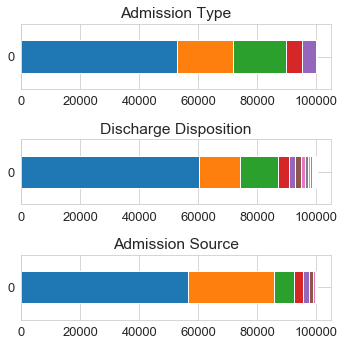

In [246]:
#Finding out the frequency for each category
adm = df_clean.groupby(['admission_type_id']).size().sort_values(ascending = False)
dis = df_clean.groupby(['discharge_disposition_id']).size().sort_values(ascending = False)
asrc = df_clean.groupby(['admission_source_id']).size().sort_values(ascending = False)

#Creating Subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 5))

pd.DataFrame(adm).T.plot.barh(stacked=True, ax = axes[0])
axes[0].set_xlim(0,105000)
axes[0].legend().set_visible(False)
axes[0].title.set_text('Admission Type')

pd.DataFrame(dis).T.plot.barh(stacked=True, ax = axes[1])
axes[1].set_xlim(0,105000)
axes[1].legend().set_visible(False)
axes[1].title.set_text('Discharge Disposition')

pd.DataFrame(asrc).T.plot.barh(stacked=True, ax = axes[2])
axes[2].set_xlim(0,105000)
axes[2].legend().set_visible(False)
axes[2].title.set_text('Admission Source')

fig.tight_layout()

In [247]:
#Ignoring warning
pd.options.mode.chained_assignment = None  # default='warn'

# 1: Discharge to Home
c1 = (df_clean.discharge_disposition_id == 1) | (df_clean.discharge_disposition_id == 13)|(df_clean.discharge_disposition_id == 14)

#18: Null Values
c2 = (df_clean.discharge_disposition_id == 18) | (df_clean.discharge_disposition_id == 25)

#remaining Values except 3, 6, in others: 29 as others
c3 = (df_clean.discharge_disposition_id != 1) & (df_clean.discharge_disposition_id != 3) & (df_clean.discharge_disposition_id != 6) & (df_clean.discharge_disposition_id != 18)

df_clean.discharge_disposition_id[c1] = 1
df_clean.discharge_disposition_id[c2] = 18
df_clean.discharge_disposition_id[c3] = 29

In [248]:
#Admission Type
#remaining Values except 1,2,3 in others: 4 as others
a1 = (df_clean.admission_type_id != 1) & (df_clean.admission_type_id != 2) & (df_clean.admission_type_id != 3)

df_clean.admission_type_id[a1] = 4

#Admission Source
# 9: Null values
c1 = (df_clean.admission_source_id == 9) | (df_clean.admission_source_id == 17)|(df_clean.admission_source_id == 20)

#remaining Values except 1, 7 in others: 26 as others
c2 = (df_clean.admission_source_id != 1) & (df_clean.admission_source_id != 7) & (df_clean.admission_source_id != 9)

df_clean.admission_source_id[c1] = 9
df_clean.admission_source_id[c2] = 26

#### A patient has visited many times in the hospital. Re-admission rates migh also depend. So creating  a new feature for the number of times a patient has visited the hospital. Therafter dropping the encounter id and patient nbr columns

In [249]:
#Using Rank method to determine the visit number. This would be ordered based on encounter_id.
df_clean['visit_num'] = df_clean.groupby("patient_nbr")["encounter_id"].rank("dense")

#Grouping the patient Visits
df_clean['visit_num'] = df_clean.visit_num.apply(lambda x: '>3' if x > 3 else str(x))

#Dropping ID columns
df_clean = df_clean.drop(['encounter_id','patient_nbr'], axis = 1)

Converting to categories to reduce memory space

In [250]:
#Selecting string columns
cat_names = list(df_clean.select_dtypes(include='object').columns)
cat_names_2 = ['admission_type_id','discharge_disposition_id','admission_source_id']
cat_names.extend(cat_names_2)

#Converting to categories
df_clean[cat_names] = df_clean[cat_names].astype('category')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100110 entries, 0 to 101765
Data columns (total 44 columns):
race                        100110 non-null category
gender                      100110 non-null category
age                         100110 non-null category
admission_type_id           100110 non-null category
discharge_disposition_id    100110 non-null category
admission_source_id         100110 non-null category
time_in_hospital            100110 non-null int64
num_lab_procedures          100110 non-null int64
num_procedures              100110 non-null int64
num_medications             100110 non-null int64
number_outpatient           100110 non-null int64
number_emergency            100110 non-null int64
number_inpatient            100110 non-null int64
diag_1                      100110 non-null category
diag_2                      100110 non-null category
diag_3                      100110 non-null category
number_diagnoses            100110 non-null int64
max_glu_seru

### Exploratory Data Analysis

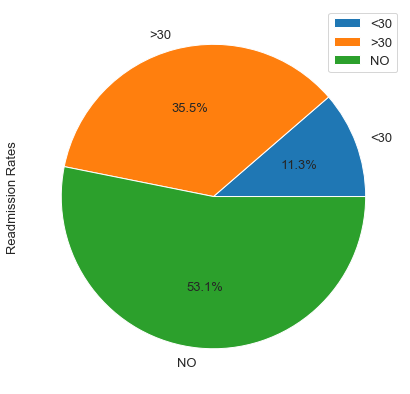

In [251]:
#Setting Figure Size
figsize(7,7)

#Exploring Hospital Readmission Rates
readm_rate = pd.DataFrame(df_clean.groupby('readmitted').size())
readm_rate = readm_rate.unstack(0)
readm_rate = pd.DataFrame(readm_rate, columns = ['Readmission Rates'])
readm_rate = readm_rate.droplevel(level = 0)

#Plotting a pie chart
_ = readm_rate.plot(y = readm_rate.columns, kind='pie',autopct='%1.1f%%')

#### It is expected that readmission rates would change with each visit number for patients. 

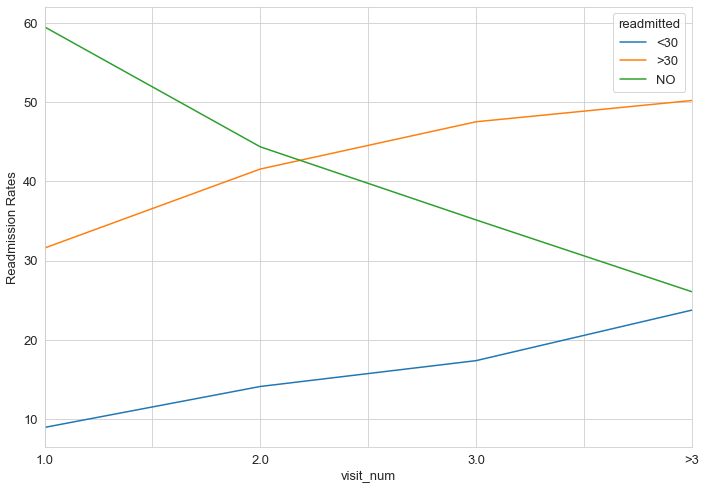

In [252]:
#Setting Figure Size
figsize(10,7)

#Visualizing relation between Visit Number and readmission rates
visit = df_clean.groupby(['visit_num','readmitted']).size()
visit = visit.unstack(1)

#Normalizing 
visit = visit.divide(visit.sum(axis=1), axis=0)*100

#Plotting line graph
_ = visit.plot()
_ = plt.ylabel('Readmission Rates')
plt.tight_layout()

In [253]:
## Converting the problem into a binary class problem. "<30 and >30" as Readmission while "No" as Not Readmission

readmitted_dict = {'NO': '0', '>30': '1', '<30': '1'}
df_clean.readmitted = df_clean.readmitted.map(readmitted_dict)

#### Understanding the 21 feature of Medicines, Glucose serum test and A1Cresult 

In [254]:
#Creating a separate data frame of medicines and tests
medicines = ['max_glu_serum','A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide',
             'tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','insulin',
             'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone',
             'metformin-pioglitazone','readmitted']
df_med = df_clean[medicines]


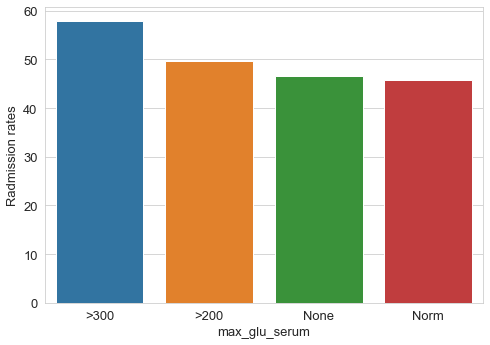

In [200]:
# Grouping max_glu_serum and Readmitted Columns
glu_serum = df_med.groupby(['max_glu_serum','readmitted']).size().unstack()

#Normalizing i.e Calculating %Readmission
glu_serum = (glu_serum.divide(glu_serum.sum(axis=1), axis=0))*100

#Renaming the column index from category to string and sorting based on %
glu_serum = glu_serum.rename(columns=str).reset_index()
glu_serum.sort_values('1',ascending = False, inplace = True)

#Setting Figure size and plotting the bar chart
fig_dims = (7, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = glu_serum, x = 'max_glu_serum',y='1', ax = ax, order = glu_serum['max_glu_serum'])
plt.ylabel('Radmission rates')
plt.tight_layout()


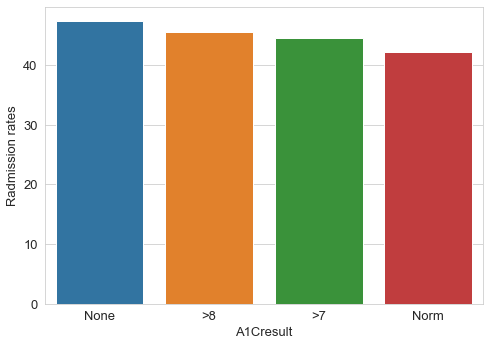

In [201]:
figsize(5,5)
# Grouping A1CResult and Readmitted Columns
ac = df_med.groupby(['A1Cresult','readmitted']).size().unstack()

#Normalizing i.e. Calculating %Readmission
ac= (ac.divide(ac.sum(axis=1), axis=0))*100

#Renaming the column index from category to string
ac = ac.rename(columns=str).reset_index()
ac.sort_values('1',ascending = False, inplace = True)

#Setting Figure size and plotting the bar chart
fig_dims = (7, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(data = ac, x = 'A1Cresult',y='1', ax = ax, order = ac['A1Cresult'])
plt.ylabel('Radmission rates')
plt.tight_layout()

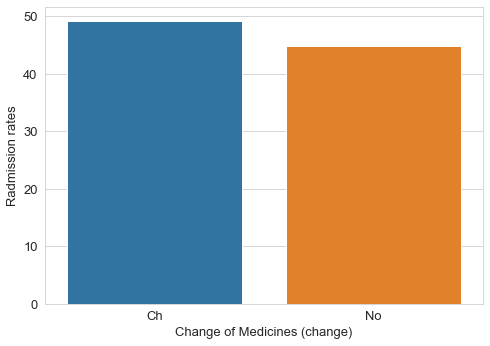

In [202]:
#Grouping change of medications and Readmitted.
change = df_clean.groupby(['change','readmitted']).size().unstack()

#Normalizing
change = (change.divide(change.sum(axis=1), axis=0))*100

#Renaming the column index from category to string
change = change.rename(columns=str).reset_index()
change.sort_values('1',ascending = False, inplace = True)

#Plotting the bar Graph
figsize(7,5)
sns.barplot(data = change, x = 'change',y='1', order = change['change'])
plt.ylabel('Radmission rates')
plt.xlabel('Change of Medicines (change)')
plt.tight_layout()

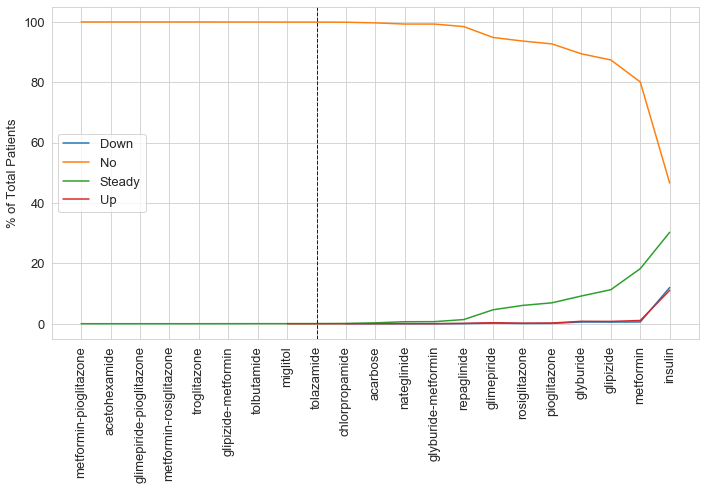

In [203]:
#Extracting 21 features of medicines
med = pd.DataFrame()
x = df_med.drop(['max_glu_serum','A1Cresult','readmitted'], axis = 1)
for col in x.columns:
    med_s = df_med[col].value_counts()
    med = pd.concat([med,med_s],axis = 1) 
med = pd.DataFrame(med.stack())
med = med.unstack(0)
med.columns = med.columns.droplevel(0)
med.sort_values('No',inplace = True, ascending = False)

#Normalizing
med = med.divide(med.sum(axis=1), axis=0)*100

#Plotting the graph
figsize(10,7)
_ = plt.plot(med)
_ = plt.xticks(rotation=90) 
_ = plt.legend(labels = med.columns, loc = 'center left')
_ = plt.axvline(x='tolazamide', color='b', linestyle='dashed', linewidth=1)
_ = plt.ylabel('% of Total Patients')
plt.tight_layout()

#### Understanding Patient Characteristics of the data set and its relation with the Readmission rates

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


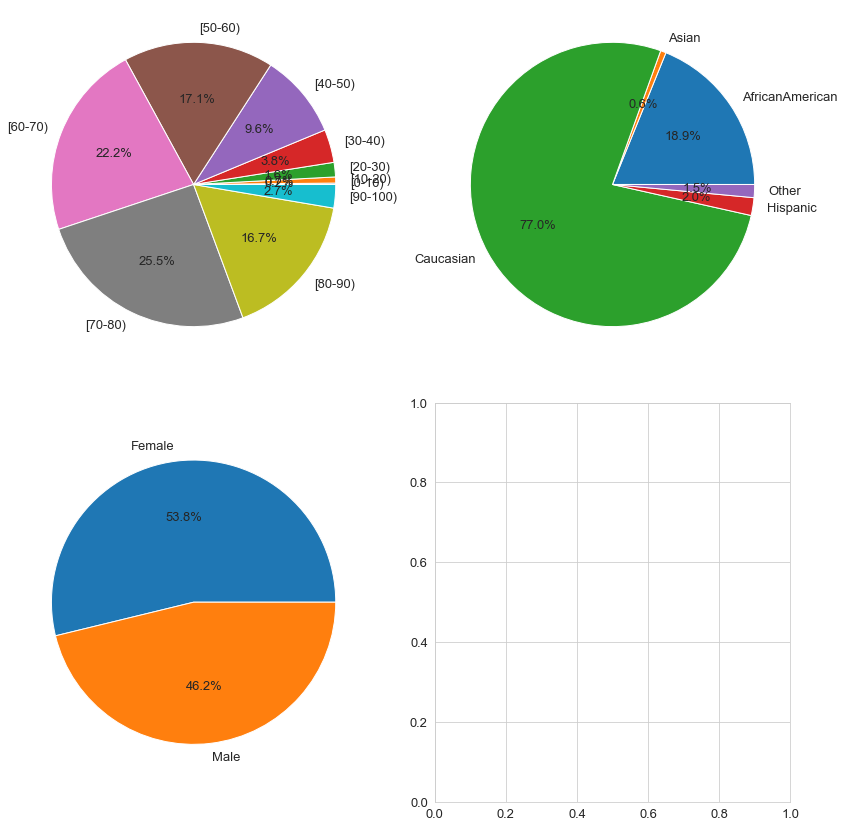

In [132]:
#Extracting relevant Features
age_d = pd.DataFrame(df_clean.groupby(['age']).size(), columns = ['count'])
race_d = pd.DataFrame(df_clean.groupby(['race']).size(), columns = ['count'])
gen_d = pd.DataFrame(df_clean.groupby(['gender']).size(), columns = ['count'])

fig_dims = (12, 12)
fig, axis = plt.subplots(nrows = 2, ncols = 2, figsize=fig_dims)

#Plotting the pie chart to see distribution of categories
axis[0,0].pie(age_d, labels = age_d.index, autopct='%1.1f%%')
axis[0,1].pie(race_d, labels = race_d.index, autopct='%1.1f%%')
axis[1,0].pie(gen_d, labels = gen_d.index, autopct='%1.1f%%')

plt.tight_layout()

#### Checking the Distribution of Race for <30 category of Readmission. Caucasian Race has higher chance of readmission.

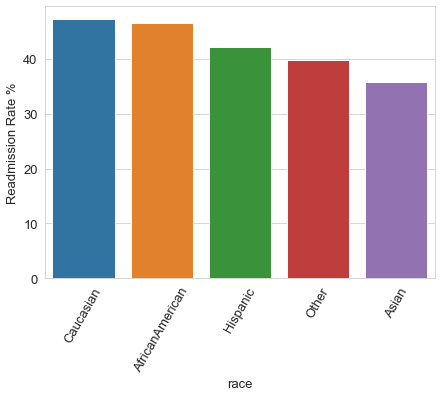

In [204]:
#Grouping Race and Readmitted.
race = df_clean.groupby(['race','readmitted']).size().unstack()

#Normalizing
race = race.divide(race.sum(axis=1), axis=0)*100

#Renaming the column index from category to string
race = race.rename(columns=str).reset_index()
race.sort_values('1',ascending = False, inplace = True)

#Plotting the bar Graph
figsize(7,5)
_ = sns.barplot(data = race, x = 'race',y='1', order = race['race'])
_ = plt.xticks(rotation=60) 
_ = plt.ylabel('Readmission Rate %')

#### Distribution of Age for <30 category of Readmission. Patient with >40 age have high chances of getting readmitted.

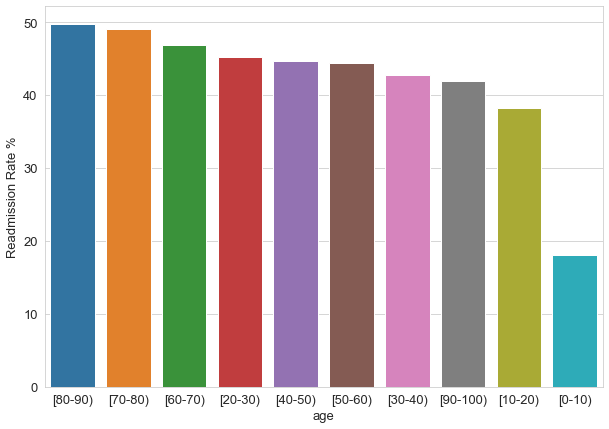

In [205]:
# Grouping Age and Readmitted Columns
age = df_clean.groupby(['age','readmitted']).size().unstack()

#Normalizing
age = age.divide(age.sum(axis=1), axis=0)*100

#Renaming the column index from category to string
age = age.rename(columns=str).reset_index()
age.sort_values('1',ascending = False, inplace = True)

#Setting Figure size and plotting the bar chart
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)
_ = sns.barplot(data = age, x = 'age',y='1', ax = ax, order = age['age'])
_ = plt.ylabel('Readmission Rate %')

#### Distribution of Gender and Readmission Rates

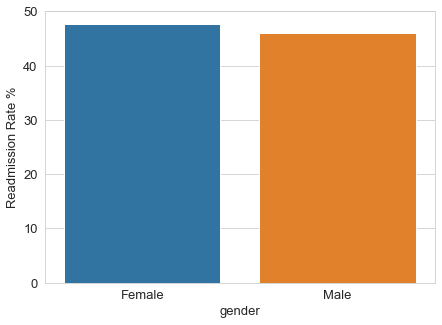

In [206]:
# Grouping gender and Readmitted Columns
gender = df_clean.groupby(['gender','readmitted']).size().unstack()

#Normalizing
gender = gender.divide(gender.sum(axis=1), axis=0)*100

#Renaming the column index from category to string
gender = gender.rename(columns=str).reset_index()
gender.sort_values('1',ascending = False, inplace = True)

#Setting Figure size and plotting the bar chart
fig_dims = (7, 5)
fig, ax = plt.subplots(figsize=fig_dims)
_ = sns.barplot(data = gender, x = 'gender',y='1', ax = ax, order = gender['gender'])
_ = plt.ylabel('Readmission Rate %')

#### Distribution of admission and Discharge features shows that, emergency patients have high chances of getting admitted (ID 7 and 1 represents emergency). Patient getting discharge and going home have lower chances of readmission

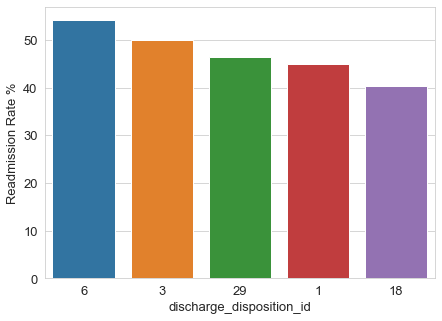

In [207]:
# Grouping Discharge Disposition and Readmitted Columns
dis = df_clean.groupby(['discharge_disposition_id','readmitted']).size().unstack()

#Normalizing
dis = dis.divide(dis.sum(axis=1), axis=0)*100

#Renaming the column index from category to string
dis = dis.rename(columns=str).reset_index()
dis.sort_values('1',ascending = False, inplace = True)

#Setting Figure size and plotting the bar chart
fig_dims = (7, 5)
fig, ax = plt.subplots(figsize=fig_dims)
_ = sns.barplot(data = dis, x = 'discharge_disposition_id',y='1', ax = ax, order = dis['discharge_disposition_id'])
_ = plt.ylabel('Readmission Rate %')

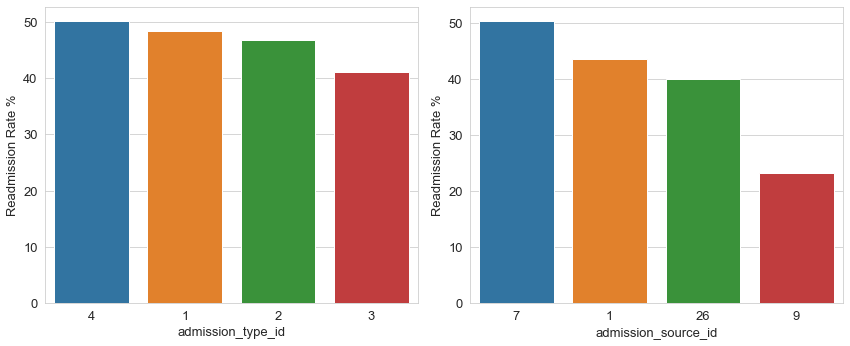

In [209]:
# Grouping Admission type and source and Readmitted Columns
adm_type = df_clean.groupby(['admission_type_id','readmitted']).size().unstack()
adm_so = df_clean.groupby(['admission_source_id','readmitted']).size().unstack()

#Normalizing
adm_type = adm_type.divide(adm_type.sum(axis=1), axis=0)*100
adm_so = adm_so.divide(adm_so.sum(axis=1), axis=0)*100

#Renaming the column index from category to string
adm_type = adm_type.rename(columns=str).reset_index()
adm_so = adm_so.rename(columns=str).reset_index()
adm_type.sort_values('1',ascending = False, inplace = True)
adm_so.sort_values('1',ascending = False, inplace = True)

#Setting Figure size and plotting the bar chart
fig_dims = (12, 5)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=fig_dims)
sns.barplot(data = adm_type, x = 'admission_type_id',y='1', ax = ax[0], order = adm_type['admission_type_id'])
sns.barplot(data = adm_so, x = 'admission_source_id',y='1', ax = ax[1], order = adm_so['admission_source_id'])

ax[0].set_ylabel('Readmission Rate %')
ax[1].set_ylabel('Readmission Rate %')
plt.tight_layout()

#### Determining relation between readmission rates and daignosis features

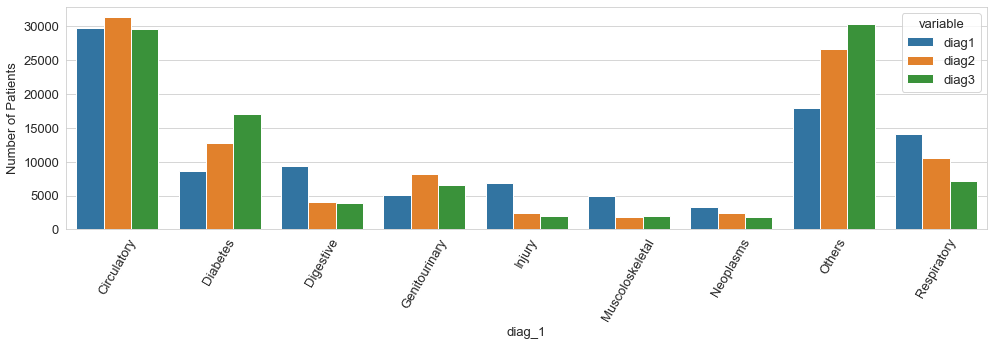

In [210]:
## Grouping all diag columns
diag = pd.DataFrame(df_clean.groupby(['diag_1']).size(), columns = ['diag1'])
cer2 = dict(df_clean.groupby(['diag_2']).size(), columns = ['d2'])
cer3 = dict(df_clean.groupby(['diag_3']).size(), columns = ['d3'])

diag = diag.rename(columns=str).reset_index()

diag['diag2'] = diag.diag_1.map(cer2)
diag['diag3'] = diag.diag_1.map(cer3)
diag = pd.melt(diag, id_vars = ['diag_1'],value_vars = ['diag1','diag2','diag3']).reset_index()

#Plotting the distribution of diagnosis for diag1,diag2 and diag3
fig_dims = (14, 5)
fig, ax = plt.subplots(figsize=fig_dims)

chart = sns.barplot(data = diag, x = 'diag_1',y='value', hue = 'variable' )
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
ax.set_ylabel('Number of Patients')
plt.tight_layout()

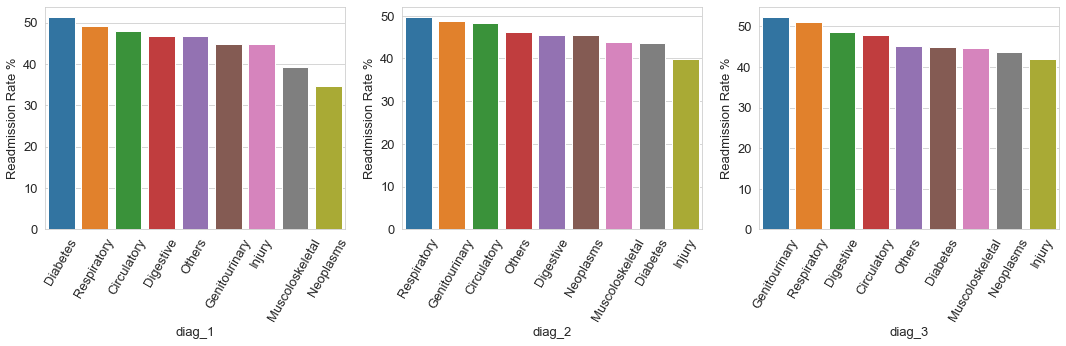

In [211]:
#Plotting realation between each diag column and readmission rate
diag_col = [(0,'diag_1'),(1,'diag_2'),(2,'diag_3')]

fig_dims = (15, 5)
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=fig_dims)

for i,col in diag_col:
    #Grouping Columns
    diag = df_clean.groupby([col, 'readmitted']).size().unstack()
    
    #Normalizing
    diag = diag.divide(diag.sum(axis=1), axis=0)*100
    
    #Renaming the column index from category to string
    diag = diag.rename(columns=str).reset_index()
    diag.sort_values('1',ascending = False, inplace = True)
    
    #Plotting the bar graphs
    chart = sns.barplot(data = diag, x = col ,order = diag[col], y='1', ax = ax[i])#, hue = diag[col])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
    ax[i].set_ylabel('Readmission Rate %')
    plt.tight_layout()

### Distribution of Discrete Numeric Variables

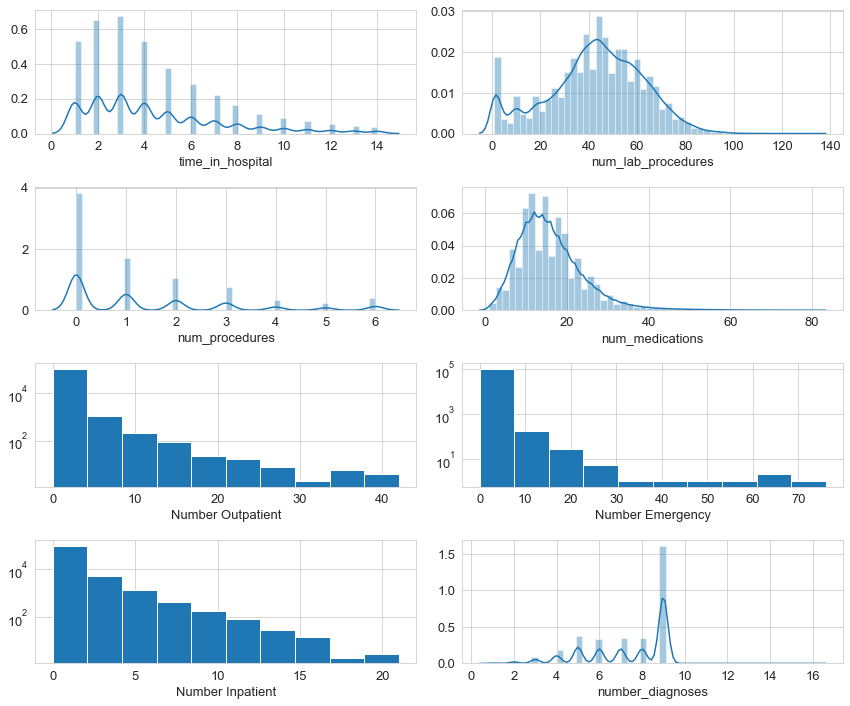

In [140]:
#Plotting existing distribution of Count Variables

fig_dims = (12, 10)
fig, ax = plt.subplots(nrows = 4, ncols = 2,figsize=fig_dims)

#Plot Graphs
sns.distplot(df_clean.time_in_hospital,ax=ax[0][0])
sns.distplot(df_clean.num_lab_procedures,ax=ax[0][1])
sns.distplot(df_clean.num_procedures,ax=ax[1][0])
sns.distplot(df_clean.num_medications,ax=ax[1][1])
sns.distplot(df_clean.number_diagnoses,ax=ax[3][1])
ax[2][0].hist(df_clean.number_outpatient)
ax[2][1].hist(df_clean.number_emergency)
ax[3][0].hist(df_clean.number_inpatient)

#Set X axis title
ax[2][0].set_xlabel('Number Outpatient')
ax[2][1].set_xlabel('Number Emergency')
ax[3][0].set_xlabel('Number Inpatient')

#Set y-axis to log scale for better visualization
ax[2][0].set_yscale('log')
ax[2][1].set_yscale('log')
ax[3][0].set_yscale('log')

fig.tight_layout()

#### Visually exploring to see which numeric variables show difference in distribution readmission (<30) and no readmission (>30, NO)

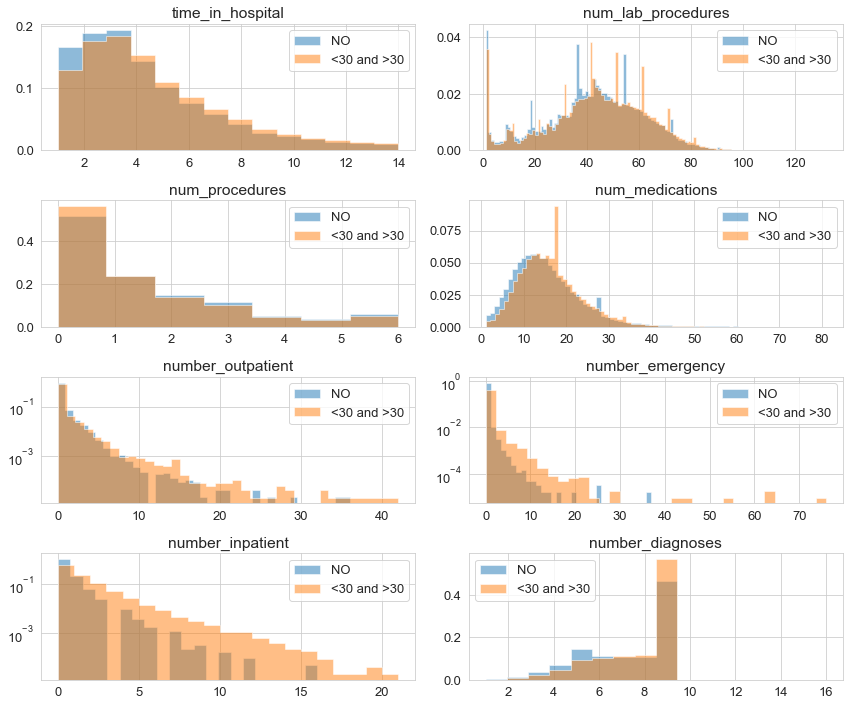

In [141]:
#Checking the distribution of the data set again
figsize(12,10)
 
#Condition whether the readmission is <30 or not
condition1 = df_clean.readmitted == 'NO'

#Selecting only Numeric columns from the df_clean2
df_numeric = df_clean.select_dtypes(include='int64')
numeric_col = df_numeric.columns

#Making bin size equal to number of unique values in the columns 
bins = [ len(df_numeric.iloc[:,i].unique()) for i in range(len(numeric_col))]

x = [1,2,3,4,5,6,7,8]

#For Loop to plot graphs for all the features together
for i in range(4):
    plt.subplot(4,2, x[2*i])
    plt.title(numeric_col[2*i])
    plt.hist(df_numeric[condition1].iloc[:,2*i],bins = bins[2*i], alpha = 0.5, label='NO', density = True, histtype = 'stepfilled')
    plt.hist(df_numeric[~condition1].iloc[:,2*i],bins = bins[2*i], alpha = 0.5, label='<30 and >30', density = True, histtype = 'stepfilled')
    #plt.hist(df_numeric[condition3].iloc[:,2*i],bins = bins[2*i], alpha = 0.5, label='NO', density = True, histtype = 'stepfilled')
    if((numeric_col[2*i] == 'number_inpatient') | (numeric_col[2*i] == 'number_outpatient') | 
       (numeric_col[2*i] == 'number_emergency')):
        plt.yscale('log')
    plt.legend()

    plt.subplot(4,2, x[2*i + 1])
    plt.title(numeric_col[2*i + 1])
    plt.hist(df_numeric[condition1].iloc[:,2*i + 1],bins = bins[2*i + 1], alpha = 0.5, label='NO', density = True, histtype = 'stepfilled')
    plt.hist(df_numeric[~condition1].iloc[:,2*i + 1],bins = bins[2*i + 1], alpha = 0.5, label='<30 and >30', density = True, histtype = 'stepfilled')
    #plt.hist(df_numeric[condition3].iloc[:,2*i + 1],bins = bins[2*i + 1], alpha = 0.5, label='NO', density = True, histtype = 'stepfilled')
    if((numeric_col[2*i+1] == 'number_inpatient') | (numeric_col[2*i] == 'number_outpatient') | (numeric_col[2*i] == 'number_emergency')):
        plt.yscale('log')    
    if(numeric_col[2*i+1] == 'number_diagnoses'):
        plt.legend(loc = 'upper left')
    else:
        plt.legend()
    
plt.tight_layout()  


#### Above charts shows that except for num_procedures and number_outpatient all variables are correlated to readmission rates. For readmission, the distribution shifts towards the right. We will use now some statistics to prove our new finding

#### Using Bootstrapped Hypothesis Test to determine statistical signification for above features

In [142]:
# Defining Functions for Bootstrapping

np.random.seed(47)
N_rep = 20000

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)


def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)
    
    return bs_replicates

In [143]:
%%time
#Defining our test statistics 
reps_diff_of_mean = pd.DataFrame(columns = numeric_col)
obs_diff_of_mean = np.empty(shape = 8)

#Loop to calculate P-value for each columns
for i in range(8):
    #Sample for Readmission
    s1 = df_numeric[condition1].iloc[:,i]
    n1 = len(s1)
    
    #Sample for Non-Readmission
    s0 = df_numeric[~condition1].iloc[:,i]
    n0 = len(s0)

    #Calculating overall mean of the column
    combined_mean = np.mean(df_numeric.iloc[:,i])
    
    #Observed difference of mean between two samples
    obs_diff_of_mean[i] = np.mean(s1) - np.mean(s0)

    #Shifting the data for Bootstrapping
    shifted_0 = s0+combined_mean-np.mean(s0)
    shifted_1 = s1+combined_mean-np.mean(s1)

    #Calculating bootstrap replicates
    bs_reps_0 = draw_bs_reps(shifted_0,np.mean,size = N_rep)
    bs_reps_1 = draw_bs_reps(shifted_1,np.mean,size = N_rep)

    #Calculating difference of means for replicates
    reps_diff_of_mean.iloc[:,i] = bs_reps_1 - bs_reps_0
    
    #Calculating p-value
    if obs_diff_of_mean[i] >0:
        p = np.sum(reps_diff_of_mean.iloc[:,i] >= obs_diff_of_mean[i]) / len(reps_diff_of_mean.iloc[:,i])
    else:
        p = np.sum(reps_diff_of_mean.iloc[:,i] <= obs_diff_of_mean[i]) / len(reps_diff_of_mean.iloc[:,i])
    
    print(numeric_col[i], ' p-value =', p*2)
    

time_in_hospital  p-value = 0.0
num_lab_procedures  p-value = 0.0
num_procedures  p-value = 0.0
num_medications  p-value = 0.0
number_outpatient  p-value = 0.0
number_emergency  p-value = 0.0
number_inpatient  p-value = 0.0
number_diagnoses  p-value = 0.0
Wall time: 7min 31s


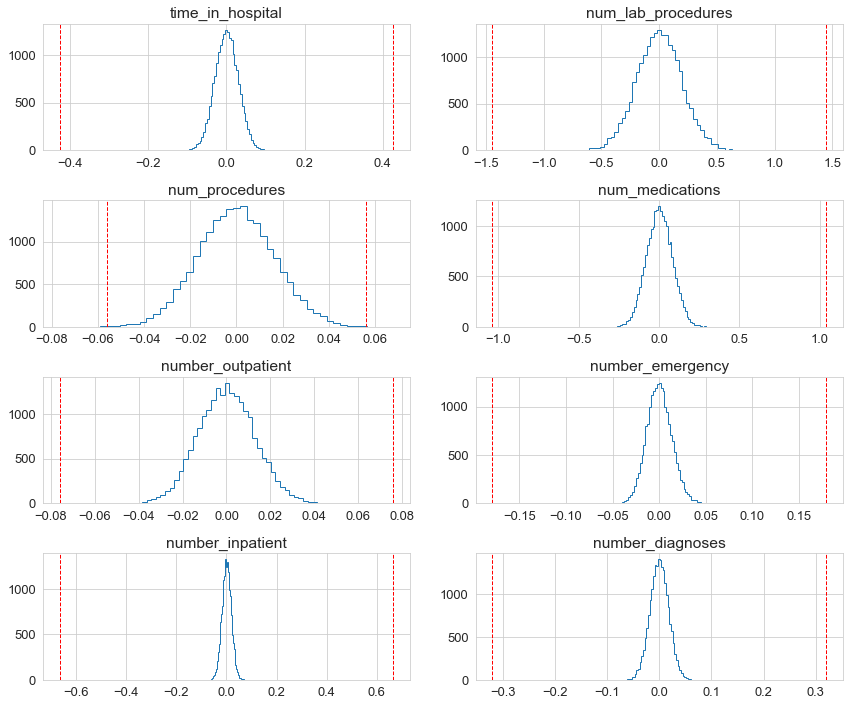

In [102]:
figsize(12,10)

#Plotting the above results graphically
for i in range(4):
    plt.subplot(4,2, x[2*i])
    plt.title(numeric_col[2*i])
    plt.hist(reps_diff_of_mean.iloc[:,2*i], bins = 50, histtype='step')
    plt.axvline(x=obs_diff_of_mean[2*i], color='r', linestyle='dashed', linewidth=1)
    plt.axvline(x=-obs_diff_of_mean[2*i], color='r', linestyle='dashed', linewidth=1)
    
    plt.subplot(4,2, x[2*i + 1])
    plt.title(numeric_col[2*i + 1])
    plt.hist(reps_diff_of_mean.iloc[:,2*i + 1], bins = 50, histtype='step')
    plt.axvline(x=obs_diff_of_mean[2*i + 1], color='r', linestyle='dashed', linewidth=1)
    plt.axvline(x=-obs_diff_of_mean[2*i + 1], color='r', linestyle='dashed', linewidth=1)
    
plt.tight_layout()

#### Performing Chi-square tests on 21 features of Medicines and dependent variable i.e readmitted

In [144]:
#Extracting Column Names
cols = df_med.iloc[:,0:23].columns


#Creating data frame to store results of Chi-Square test for all columns
result = pd.DataFrame(columns = ['Feature','Chi2','Test_stat','Degrees of Freedom'])
result['Feature'] = cols
result = result.set_index('Feature')

#Performing Chi-Square Test for all medicing columns using for loop
for col in cols:
    #Building Contigency Table
    contingency_table = pd.crosstab(df_med.readmitted,df_med[col])
    #print(contingency_table)
    i = contingency_table.shape[1]
    #Converting Contigency Table to array
    f_obs = np.array([contingency_table.iloc[0][0:i].values,
                      contingency_table.iloc[1][0:i].values,
                      contingency_table.iloc[2][0:i].values])
    #Storing the results
    result['Chi2'].loc[col] = round(stats.chi2_contingency(f_obs)[0],3)
    result['Test_stat'].loc[col] = round(stats.chi2_contingency(f_obs)[1],4)
    result['Degrees of Freedom'].loc[col] = stats.chi2_contingency(f_obs)[2]


result.sort_values('Test_stat',ascending = False, inplace = True)
result

,Chi2,Test_stat,Degrees of Freedom
Feature,,,
nateglinide,3.149,0.79,6
metformin-pioglitazone,0.881,0.6436,2
tolbutamide,1.133,0.5675,2
troglitazone,1.382,0.501,2
metformin-rosiglitazone,1.763,0.4142,2
glimepiride-pioglitazone,1.816,0.4032,2
acetohexamide,1.816,0.4032,2
glipizide-metformin,1.912,0.3844,2
tolazamide,5.379,0.2505,4


### Understanding Multi-Collinearity in the independent variables

#### 1) Patient Encounter Variables

([], <a list of 0 Text xticklabel objects>)

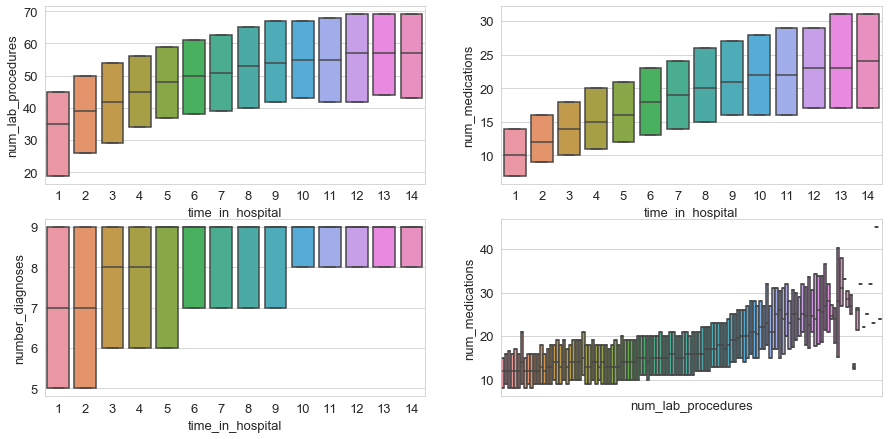

In [255]:
figsize(15,15)

#Plotting box plots without whiskers between various numeric variables
plt.subplot(4,2,1)
sns.boxplot(data = df_clean, x = 'time_in_hospital', y = 'num_lab_procedures', whis = 0, showfliers=False)

plt.subplot(4,2,2)
sns.boxplot(data = df_clean, x = 'time_in_hospital', y = 'num_medications',whis = 0, showfliers=False)

plt.subplot(4,2,3)
sns.boxplot(data = df_clean, x = 'time_in_hospital', y = 'number_diagnoses',whis = 0, showfliers=False)

plt.subplot(4,2,4)
sns.boxplot(data = df_clean, x = 'num_lab_procedures', y = 'num_medications',whis = 0, showfliers=False)
plt.xticks(ticks = [])

In [256]:
#Verifing the above visual results using Pearson Correlation
y = np.cov(df_clean.time_in_hospital,df_clean.num_lab_procedures)
corr, _ = stats.pearsonr(df_clean.num_medications,df_clean.time_in_hospital)
print(corr)

0.4640878470768858


#### 2) Patient Admission and discharge Variables

In [257]:
#Building Contigency Table to check multi-collinearity between discharge disposition and admission_type
contingency_table = pd.crosstab(df_clean.discharge_disposition_id,df_clean.admission_type_id)
i = contingency_table.shape[1]
#Converting Contigency Table to array
f_obs = np.array([contingency_table.iloc[0][0:i].values,
                  contingency_table.iloc[1][0:i].values,
                  contingency_table.iloc[2][0:i].values,
                  contingency_table.iloc[3][0:i].values,
                  contingency_table.iloc[4][0:i].values])
#Storing the results
stats.chi2_contingency(f_obs)[0:3]


(1999.093880090593, 0.0, 12)

#### 3) Multi-Collinearity between medicine features and change columns

In [259]:
df_vif = df_clean#.drop('readmitted', axis=1)
corr_matrix = df_vif.corr()

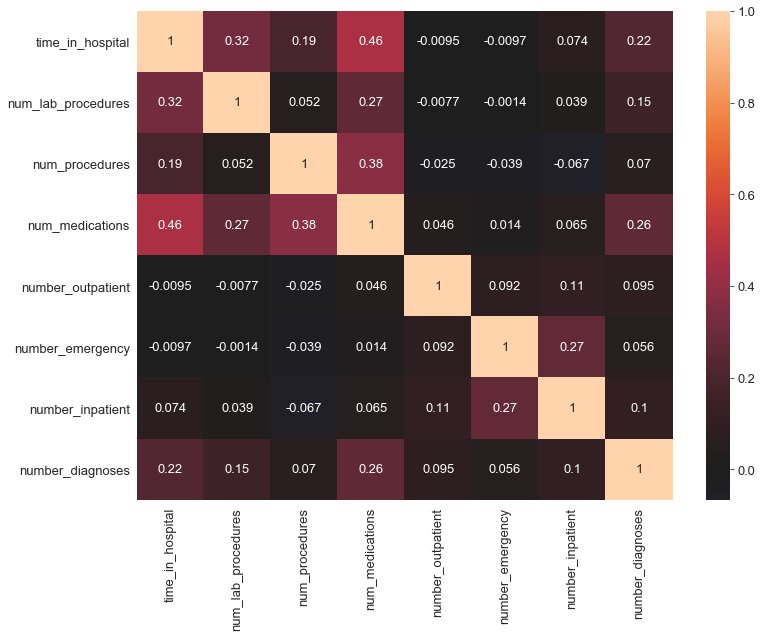

In [260]:
figsize(12,9)
_ = sns.heatmap(corr_matrix, center = 0, annot=True)

In [96]:
df_clean.to_csv('df_clean2.csv',index = False)

In [261]:
df_clean.shape

(100110, 44)

In [264]:
df_clean.readmitted.value_counts(normalize = True)

0    0.531495
1    0.468505
Name: readmitted, dtype: float64